# **1. Introduction**

In this notebook, we implement and train three different types of classifiers to predict the similarity score between pairs of sentences based on the extracted features.

We will identify the best model and compare our results with various alternatives, including using only lexical features, only syntactic features, or a combination of both. Additionally, we will compare our results against the official benchmarks.

We will also perform a feature importance analysis to determine which features are most influential in assessing the similarity between sentences. Furthermore, we will analyze the role and significance of lexical and semantic features to assess whether one type of feature is more effective than the other in determining if a pair of sentences are paraphrases.

In [ ]:
# Install the necessary libraries
%pip install pandas numpy scikit-learn matplotlib scipy joblib

In [5]:
# Import the required libraries
import pandas as pd
import joblib

First, we load the preprocessed training and test datasets, as well as the extracted features for both the training and test datasets.

In [6]:
# Load Training and Test Datasets
train_data = pd.read_csv('datasets/train_preprocessed.csv')
test_data  = pd.read_csv('datasets/test_preprocessed.csv')

# Load Training and Test Features
features_train = pd.read_csv('features/features_train.csv')
features_test  = pd.read_csv('features/features_test.csv')

Secondly, we decided to shuffle the training features to eliminate any spatial bias. Currently, the features are sorted by dataset, with consecutive entries corresponding to the same dataset. Since we train our models using cross-validation, some folds may contain features from only a single dataset, potentially causing the model to become biased or overfitted to that dataset. To prevent this, we randomly shuffle the features, thereby avoiding such issues and enhancing the training process of our models.

In [7]:
from sklearn.utils import shuffle

features_train_shuffled, score_shuffled = shuffle(features_train, train_data["score"], random_state=42)

As observed in the previous notebook in the Feature Visualization section, some of our features do not follow a normal distribution. Therefore, we decided to apply Yeo-Johnson transformations to modify the distribution of these features, enhancing their ability to provide more relevant information.

In [8]:
import numpy as np
from sklearn.preprocessing import PowerTransformer

# Initialize Yeo-Johnson power transformer
power_transformer = PowerTransformer(method='yeo-johnson')

# List of columns to apply log1p transformation
log_transform_cols = [
    "longest_common_substring", "longest_common_subsequence",
    "greedy_string_tiling", "3_gram_word_Jaccard",
    "4_gram_word_Jaccard", "2_gram_word_Jaccard_without_SW",
    "pathlen_similarity", "lin_similarity"
]

# Apply log1p transformation to specified training features
for col in log_transform_cols:
    features_train[col] = np.log1p(features_train[col])

# Apply Yeo-Johnson transformation to selected training features
features_train[["2_gram_char", "lexical_substitution_system", "wordnet_augmented_overlap", "wordnet_augmented_word_overlap"]] = power_transformer.fit_transform(features_train[["2_gram_char", "lexical_substitution_system", "wordnet_augmented_overlap", "wordnet_augmented_word_overlap"]])

# Apply log1p transformation to specified test features
for col in log_transform_cols:
    features_test[col] = np.log1p(features_test[col])

# Apply the Yeo-Johnson transformation to selected test features
features_test[["2_gram_char", "lexical_substitution_system", "wordnet_augmented_overlap", "wordnet_augmented_word_overlap"]] = power_transformer.transform(features_test[["2_gram_char", "lexical_substitution_system", "wordnet_augmented_overlap", "wordnet_augmented_word_overlap"]])

# **2. Model Training**

In this section, we train three different models and perform hyperparameter tuning using grid search for each of them.

## 2.1. Linear Regression

The first model we implemented is the Linear Regression model. We selected this model because it was used in the UKP paper [1]. We followed the same process as described in the paper, utilizing 10-fold cross-validation.

In [177]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr
import numpy as np

# Custom scorer using Pearson correlation
def pearson_corr(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

pearson_scorer = make_scorer(pearson_corr, greater_is_better=True)

# Linear Regression model
linear_model = LinearRegression()

# Perform 10-fold cross-validation
linear_scores = cross_val_score(linear_model, features_train_shuffled, score_shuffled, cv=10, scoring=pearson_scorer)

print("Linear Regression - Pearson Correlation Scores:", linear_scores)
print("Linear Regression - Mean Pearson Correlation:", linear_scores.mean())

Linear Regression - Pearson Correlation Scores: [0.77301975 0.77625646 0.79850241 0.86295146 0.78612126 0.82311474
 0.78100821 0.81608179 0.84297513 0.85075371]
Linear Regression - Mean Pearson Correlation: 0.8110784922520671


In [178]:
# Save the Linear Regression model
linear_model_path = 'models/lr_best_model.joblib'
joblib.dump(linear_model, linear_model_path)
print(f"Linear Regression model saved to {linear_model_path}")

Linear Regression model saved to models/lr_best_model.joblib


## 2.2. Random Forest Regressor

The second model we implemented is the Random Forest Regressor. We selected this model based on our judgment and the generally strong performance of tree-based models in this type of task.

In [179]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Hyperparameter Grid for Random Forest
rf_params = {
    "n_estimators": [100, 200, 400],
    "max_depth": [15, 20, 25],
    "min_samples_split": [2, 5]
}

# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=0)

# Grid Search for Random Forest
rf_grid = GridSearchCV(rf_model, rf_params, cv=10, scoring=pearson_scorer, n_jobs=-1)
rf_grid.fit(features_train_shuffled, score_shuffled)

# Best Model and Parameters
rf_best_model = rf_grid.best_estimator_
rf_best_params = rf_grid.best_params_

# Cross-validation with the Best Model
rf_best_scores = cross_val_score(rf_best_model, features_train_shuffled, score_shuffled, cv=10, scoring=pearson_scorer)

print("Random Forest - Best Parameters:", rf_best_params)
print("Random Forest - Pearson Correlation Scores:", rf_best_scores)
print("Random Forest - Mean Pearson Correlation:", rf_best_scores.mean())

Random Forest - Best Parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 400}
Random Forest - Pearson Correlation Scores: [0.83043572 0.83724441 0.85284768 0.88990846 0.81582052 0.87845474
 0.83172764 0.84873916 0.89342316 0.88679372]
Random Forest - Mean Pearson Correlation: 0.856539520181151


In [180]:
# Save the Best Random Forest model
rf_model_path = 'models/rf_best_model.joblib'
joblib.dump(rf_best_model, rf_model_path)
print(f"Best Random Forest model saved to {rf_model_path}")

Best Random Forest model saved to models/rf_best_model.joblib


## 2.3. Gradient Boosting

The third model we implemented is a Gradient Boosting Regressor. Gradient Boosting models are widely used for regression tasks, and we anticipated that this type of model could yield strong performance for our project.

In [110]:
from sklearn.ensemble import GradientBoostingRegressor

# hyperparameter Grid for Gradient Boosting
gb_params = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [5, 10, 15, 20],
    "min_samples_split": [2, 5, 7],
    "subsample": [0.5, 1.0]
}

# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=0)

# Grid Search for Gradient Boosting
gb_grid = GridSearchCV(gb_model, gb_params, cv=10, scoring=pearson_scorer, n_jobs=-1)
gb_grid.fit(features_train_shuffled, score_shuffled)

# Best Model and Parameters
gb_best_model = gb_grid.best_estimator_
gb_best_params = gb_grid.best_params_

# Cross-validation with the Best Model
gb_best_scores = cross_val_score(gb_best_model, features_train_shuffled, score_shuffled, cv=10, scoring=pearson_scorer)

print("Gradient Boosting - Best Parameters:", gb_best_params)
print("Gradient Boosting - Pearson Correlation Scores:", gb_best_scores)
print("Gradient Boosting - Mean Pearson Correlation:", gb_best_scores.mean())

c:\Users\joanc\miniconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Gradient Boosting - Best Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 400, 'subsample': 0.5}
Gradient Boosting - Pearson Correlation Scores: [0.8252087  0.83682702 0.85958563 0.88687121 0.83540937 0.88264354
 0.83548196 0.85386796 0.88752392 0.88934333]
Gradient Boosting - Mean Pearson Correlation: 0.8592762632344485


In [141]:
# Save the Best Gradient Boosting model
gb_model_path = 'models/gb_best_model.joblib'
joblib.dump(gb_best_model, gb_model_path)
print(f"Best Gradient Boosting model saved to {gb_model_path}")

Best Gradient Boosting model saved to models/gb_best_model.joblib


## **3. Model Selection**

After training all three models, we select the one that achieved the highest average Pearson correlation.

In [181]:
# Summarize the mean Pearson correlation scores for each model
models_summary = {
    "Linear Regression": {"Mean Pearson CV Score": linear_scores.mean()},
    "Random Forest": {"Mean Pearson CV Score": rf_best_scores.mean()},
    "Gradient Boosting": {"Mean Pearson CV Score": gb_best_scores.mean()},
}

# DataFrame for better visualization
models_df = pd.DataFrame(models_summary).T
print(models_df)

# Identify the best model based on the highest mean Pearson correlation
best_model_name = models_df["Mean Pearson CV Score"].idxmax()
best_model_score = models_df["Mean Pearson CV Score"].max()

print(f"Best Model: {best_model_name} with a Mean Pearson CV Score of {best_model_score}")

                   Mean Pearson CV Score
Linear Regression               0.811078
Random Forest                   0.856540
Gradient Boosting               0.859276
Best Model: Gradient Boosting with a Mean Pearson CV Score of 0.8592762632344485


In [182]:
# Select the Best Model
if best_model_name == "Linear Regression":
    model = linear_model
elif best_model_name == "Random Forest":
    model = rf_best_model
elif best_model_name == "Gradient Boosting":
    model = gb_best_model

In [183]:
# Save the Best Model
best_model_path = 'models/best_model.joblib'
joblib.dump(model, best_model_path)
print(f"Best model saved to {best_model_path}")

Best model saved to models/best_model.joblib


In [9]:
# Path to the Best Model
best_model_path = 'models/best_model.joblib'

# Load the Best Model
model = joblib.load(best_model_path)
print(f"Best model loaded from {best_model_path}")

Best model loaded from models/best_model.joblib


# **4. Test Set Evaluation**

After selecting the optimal model, we evaluate its performance on the test set.

In [185]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

# Best Parameters for Gradient Boosting
best_params = {
    "learning_rate": 0.01,
    "n_estimators": 400,
    "max_depth": 10,
    "min_samples_split": 5,
    "subsample": 0.5
}

# Gradient Boosting Regressor with Best Parameters
gb_best_model = GradientBoostingRegressor(
    learning_rate=best_params["learning_rate"],
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    subsample=best_params["subsample"],
    random_state=0
)

# Fit the model to the training data
gb_best_model.fit(features_train_shuffled, score_shuffled)

# Cross-validation with the Best Model
gb_best_scores = cross_val_score(gb_best_model, features_train_shuffled, score_shuffled, cv=10, scoring=pearson_scorer)

print("Gradient Boosting - Best Parameters:", best_params)
print("Gradient Boosting - Pearson Correlation Scores:", gb_best_scores)
print("Gradient Boosting - Mean Pearson Correlation:", gb_best_scores.mean())


Gradient Boosting - Best Parameters: {'learning_rate': 0.01, 'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 5, 'subsample': 0.5}
Gradient Boosting - Pearson Correlation Scores: [0.8252087  0.83682702 0.85958563 0.88687121 0.83540937 0.88264354
 0.83548196 0.85386796 0.88752392 0.88934333]
Gradient Boosting - Mean Pearson Correlation: 0.8592762632344485


In [186]:
# Actual scores from the test set
y_true = test_data["score"]

# Predict scores using the selected model
y_pred = gb_best_model.predict(features_test)

# Pearson correlation between actual and predicted scores
pearson_corr = pearsonr(y_true, y_pred)[0]
print("Pearson Correlation:", pearson_corr)

Pearson Correlation: 0.5605911314449616


We obtained a Pearson Correlation of 0.751 on the test data. This indicates a strong positive relationship between the actual and predicted similarity scores, suggesting that our model effectively captures the underlying patterns in the data.

# **5. Comparison with Official Results**

To contextualize our results, we compare them against the baseline and the top 10 results from the SemEval-2012 Task 6 competition.

In [5]:
# Load Official Results from SemEval-2012 Task 6
official_results = pd.read_csv('results/official_results.csv')

In [3]:
from compare_results import compute_best_results

best_model_name = 'gradient_boosting'
# Calculate Best Results
best_results = compute_best_results(best_model_name, model)

ParserError: Error tokenizing data. C error: Expected 2 fields in line 104, saw 3


In [ ]:

# Add our results to the official results DataFrame
comparison_results = pd.concat([official_results, own_results], ignore_index=True)

# Modify Official Results
#official_results.insert

# Display the comparison
print(comparison_results)

# **6. Feature Importance Analysis**

We believe it is important to identify which features are most influential in the final model for classifying each pair of sentences. Below, we present a bar chart displaying each feature sorted by their importance.

In [10]:
# Extract the importance from each feature
importances = model.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({
    'Feature': features_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


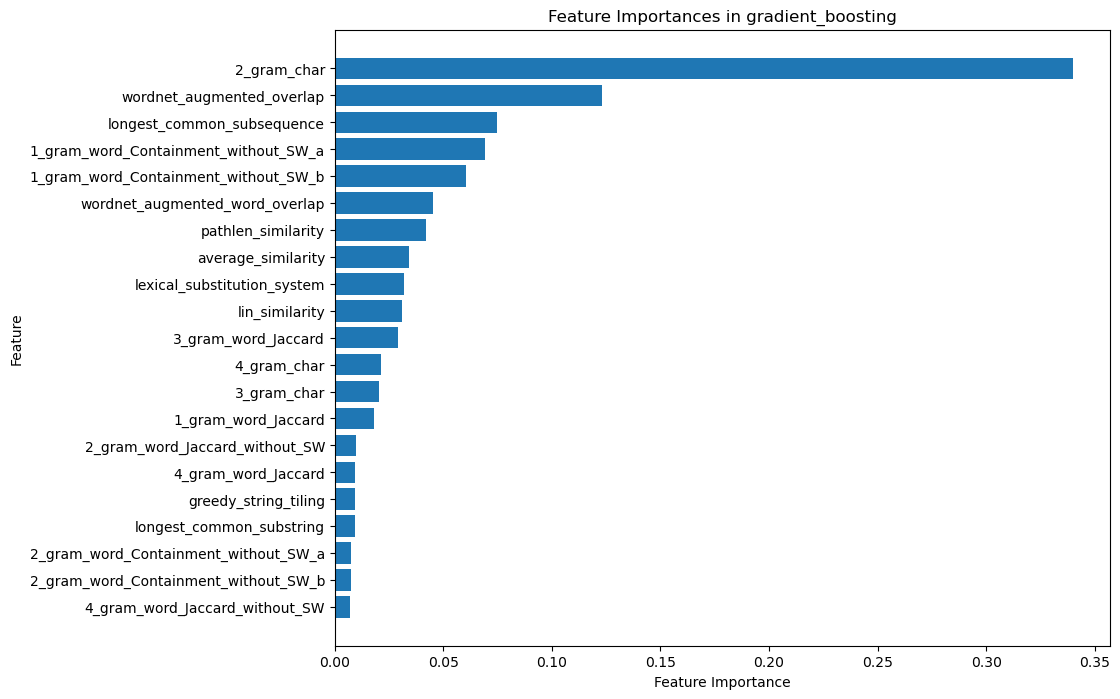

In [12]:
import matplotlib.pyplot as plt

# Plot the feature importances as a bar chart
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Feature Importances in {best_model_name}')
plt.gca().invert_yaxis() # Most important feature at the top
plt.show()

The bar chart displays the importance of each feature in the selected model. Features with higher importance scores contribute more significantly to the model's predictions, while those with lower scores have less influence.

From the chart, we observe that certain features, such as `2_gram_char` and `wordnet_augmented_overlap` have high importance, indicating they are crucial in determining sentence similarity. These features likely capture essential aspects of lexical and semantic similarity effectively. On the other hand, features like `4_gram_word_Jaccard_without_SW` and `greedy_string_tiling` show lower importance, suggesting they have a minimal impact on the model's decisions.

aqui fer feature analysis però amb importancia acumulada donada el tipus de feature (lexica o semantica) amb un bar plot en horitzontal

Overall, the analysis reveals that lexical features tend to be more influential than syntactic features in assessing sentence similarity.

# **7. Analysis with different texts**

In [ ]:
#from ... import compute_features

# Initialize a dictionary to store Pearson correlation results for each dataset
pearson_results = {}

# Iterate over each dataset within the test data
for dataset_name, group in test_data.groupby("dataset_name"):
    # Actual scores for the current dataset
    y_true = group["score"]

    # Compute features for the current group
    features_group = ... #compute_features(group)

    # Apply log1p transformation to specified features
    log_transform_cols = [
        "longest_common_substring", "longest_common_subsequence",
        "greedy_string_tiling", "3_gram_word_Jaccard",
        "4_gram_word_Jaccard", "2_gram_word_Jaccard_without_SW",
        "pathlen_similarity", "lin_similarity"
    ]
    for col in log_transform_cols:
        features_group[col] = np.log1p(features_group[col])

    # Apply the same Yeo-Johnson transformation to selected features
    features_group[["2_gram_char", "lexical_substitution_system"]] = power_transformer.transform(features_group[["2_gram_char", "lexical_substitution_system"]])

    # Predict scores using the selected model
    y_pred = model.predict(features_group)

    # Calculate Pearson correlation for the current dataset
    pearson_corr = pearsonr(y_true, y_pred)[0]

    # Store the result
    pearson_results[dataset_name] = pearson_corr

    print(f"Dataset: {dataset_name}, Pearson Correlation: {pearson_corr}")

# **Conclusions**

In this project, we successfully implemented and trained three different classifiers to predict the similarity between pairs of sentences.

# **References**